In [1]:
import pandas as pd
from statistics import mean, stdev, variance
from math import sqrt
import numpy as np
import scipy.stats
import collections
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_csv('dane/series1.csv')
df1 = df1.rename(columns={'x': 'x1'})
df2 = pd.read_csv('dane/series2.csv')
df2 = df2.rename(columns={'x': 'x2'})
df3 = pd.read_csv('dane/series3.csv')
df3 = df3.rename(columns={'x': 'x3'})

df = pd.concat([df1, df2, df3], axis=1)

In [3]:
def draw_change_points(data_source_path, change_points, means=None):
    y = 'x' + data_source_path.replace('dane/series', '').replace('.csv', '')
    plt.figure(figsize=(15, 5))
    sns.lineplot(data=df, y=y, x=range(0, 10000))
    if means is not None:
        while len(means) < 10000:
            means.insert(0, means[0])
        sns.lineplot(y=means, x=range(0, 10000))
    for point in change_points:
        plt.axvline(point, color='red')

In [4]:
def data_generator(data_source_path):
    with open(data_source_path, 'r') as f:
        for line in f:
            if 'x' in line:
                pass
            else:
                yield float(line)
        yield None

# Method 1 - using global mean (best)

We have global mean saved and updated as each data point comes. If current mean is different by defined threshold from global mean, then we assume there is a concept drift.

In [9]:
def method2(data_source_path, threshold, data_size):
    print(f'BEGIN: {data_source_path}')
    new_data = data_generator(data_source_path)

    data_set = collections.deque(data_size*[None], data_size)
    while data_set[1] is None:
        data_set.append(next(new_data))

    i = data_size
    global_mean = None

    change_ids = []
    means = []

    data = next(new_data)
    data_set.append(data)

    while data_set is not None:
        if global_mean is None:
            global_mean = mean(data_set)
        else:
            global_mean = (global_mean * (i-1) + data) / (i)

        current_mean = mean(data_set)
        current_std = stdev(data_set)
        current_threshold = current_mean * threshold
        
        means.append(current_mean)

        diff = np.absolute(global_mean - current_mean)

        if diff > current_threshold:
#             print(f'CHANGE DETECTED, global = {global_mean}, current = {current_mean}, i = {i}')
            global_mean = current_mean
            change_ids.append(i)

        data = next(new_data)
        if data is not None:
            data_set.append(data)
            i += 1
        else:
            data_set = None

    print(f'END: {data_source_path}')
    return change_ids, means

BEGIN: dane/series1.csv
END: dane/series1.csv


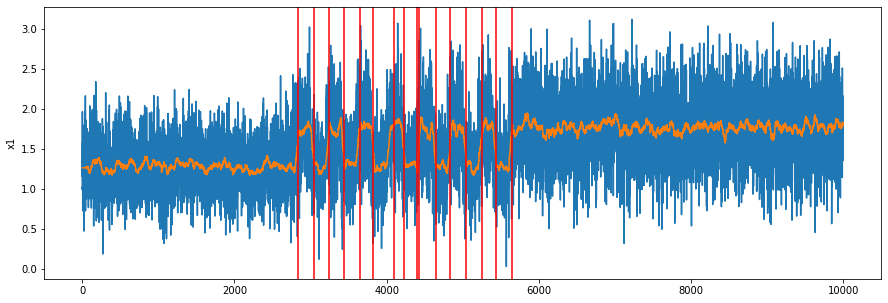

In [10]:
data_source_path = 'dane/series1.csv'
threshold = 0.2
data_size = 50

change_points, means = method2(data_source_path, threshold, data_size)
draw_change_points(data_source_path, change_points, means)

BEGIN: dane/series2.csv
END: dane/series2.csv


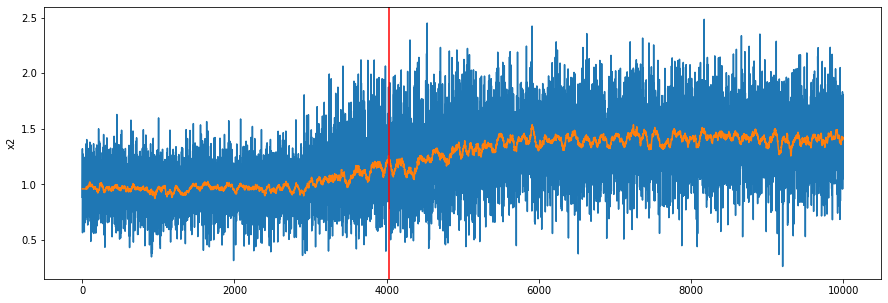

In [11]:
data_source_path = 'dane/series2.csv'
threshold = 0.2
data_size = 50

change_points, means = method2(data_source_path, threshold, data_size)
draw_change_points(data_source_path, change_points, means)

BEGIN: dane/series3.csv
END: dane/series3.csv


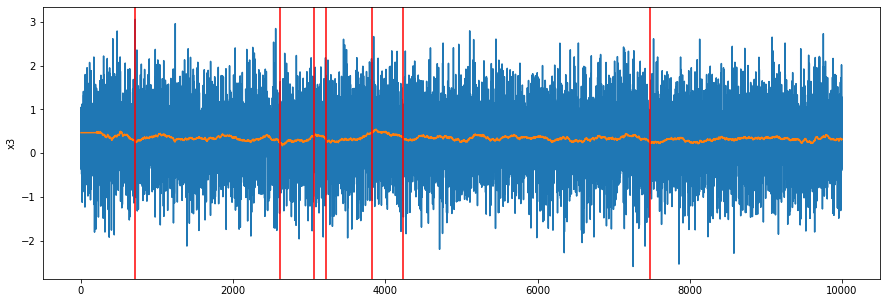

In [12]:
data_source_path = 'dane/series3.csv'
threshold = 0.4
data_size = 200

change_points, means = method2(data_source_path, threshold, data_size)
draw_change_points(data_source_path, change_points, means)

## Method 2 - means of means

Compare current mean with mean of previous means and if it's bigger than some threshold, then we assume there is a concept drift.

In [5]:
def method1(data_source_path, threshold, window_start, window_end, data_size, change_detected_window):
    print(f'BEGIN: {data_source_path}')
    
    new_data = data_generator(data_source_path)

    data_set = collections.deque(data_size*[None], data_size)
    while data_set[0] is None:
        data_set.append(next(new_data))

    means = []
    stds = []
    i = data_size

    change_ids = []
    change_detected = []

    while data_set is not None:
        current_mean = mean(data_set)
        current_std = stdev(data_set)
        current_threshold = current_mean * threshold

        if len(means) > window_end:
            mean_of_means = mean(means[-window_start:-window_end])
            diff = np.absolute(mean_of_means - current_mean)

            if diff > current_threshold:
                if not any(x in range(i-change_detected_window, i) for x in change_ids):
                    change_ids.append(i)
#                     print(f'CHANGE DETECTED, i = {i}')

        means.append(current_mean)
        stds.append(current_std)

        data = next(new_data)
        if data is not None:
            data_set.append(data)
        else:
            data_set = None
        i += 1

    print(f'END: {data_source_path}')
    return change_ids, means

BEGIN: dane/series1.csv
END: dane/series1.csv


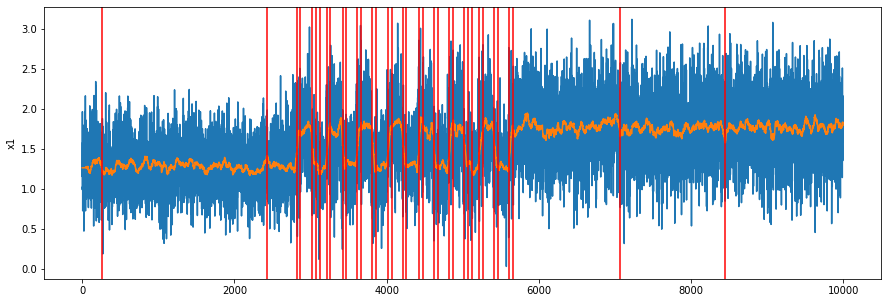

In [6]:
data_source_path = 'dane/series1.csv'
threshold = 0.1
window_start = 105
window_end = 5
data_size = 50
change_detected_window = 50

change_points, means = method1(data_source_path, threshold, window_start, window_end, data_size, change_detected_window)
draw_change_points(data_source_path, change_points, means)

BEGIN: dane/series2.csv
END: dane/series2.csv


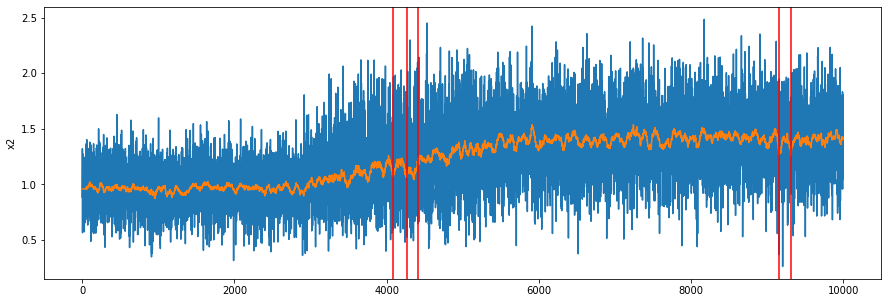

In [7]:
data_source_path = 'dane/series2.csv'
threshold = 0.1
window_start = 105
window_end = 5
data_size = 50
change_detected_window = 50

change_points, means = method1(data_source_path, threshold, window_start, window_end, data_size, change_detected_window)
draw_change_points(data_source_path, change_points, means)

BEGIN: dane/series3.csv
END: dane/series3.csv


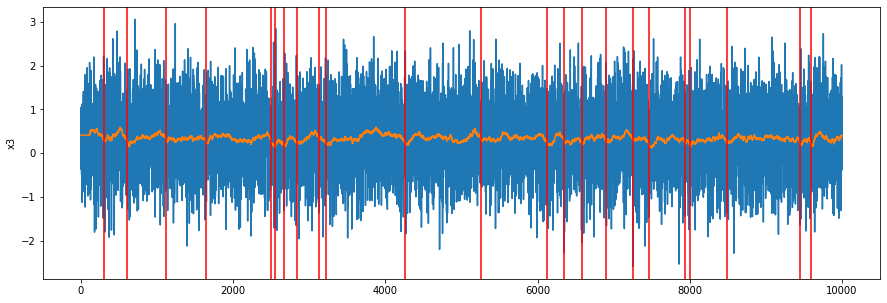

In [8]:
data_source_path = 'dane/series3.csv'
threshold = 0.5
window_start = 105
window_end = 5
data_size = 100
change_detected_window = 50

change_points, means = method1(data_source_path, threshold, window_start, window_end, data_size, change_detected_window)
draw_change_points(data_source_path, change_points, means)

## Method 3 - based on z-score difference

We compare global z-score (counted as mean of previous means) with current z-score.

In [13]:
def method3(data_source_path, threshold, window_size, data_size, change_detected_window):
    print(f'BEGIN: {data_source_path}')
    
    new_data = data_generator(data_source_path)

    data_set = collections.deque(data_size*[None], data_size)
    while data_set[0] is None:
        data_set.append(next(new_data))

    means = []
    stds = []
    i = data_size

    change_ids = []
    change_detected = []

    while data_set is not None:
        current_mean = mean(data_set)
        current_std = stdev(data_set)
        latest_observation = data_set[-1]

        if len(means) > 0:
            population_mean = mean(means[-window_size:])
            population_std = mean(stds[-window_size:])

            current_z_score = (latest_observation - current_mean)/current_std
            z_score = (latest_observation - population_mean)/population_std

        #         p_values = scipy.stats.norm.sf(abs(current_z_scores))*2

            diff = np.absolute(z_score - current_z_score)
            if diff > threshold:
    #            print(z_score, current_z_score)
                if not any(x in range(i-change_detected_window, i) for x in change_ids):
                    change_ids.append(i)
#                     print(f'CHANGE DETECTED, diff={diff}, i = {i}')
                    population_mean = current_mean

        means.append(current_mean)
        stds.append(current_std)

        data = next(new_data)
        if data is not None:
            data_set.append(data)
        else:
            data_set = None
        i += 1

    print(f'END: {data_source_path}')
    return change_ids, means

BEGIN: dane/series1.csv
END: dane/series1.csv


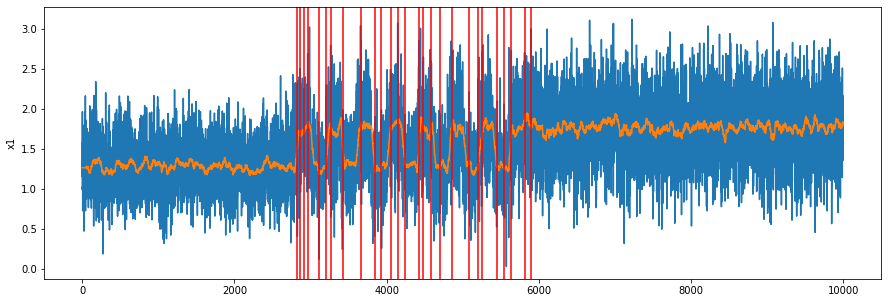

In [14]:
data_source_path = 'dane/series1.csv'
threshold = 1.0
window_size = 500
data_size = 50
change_detected_window = 50

change_points, means = method3(data_source_path, threshold, window_size, data_size, change_detected_window)
draw_change_points(data_source_path, change_points, means)

BEGIN: dane/series2.csv
END: dane/series2.csv


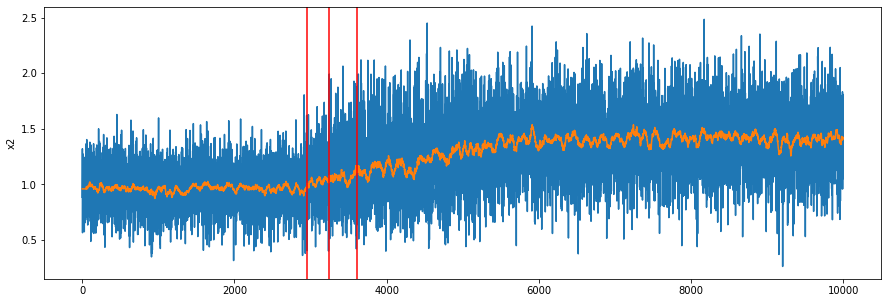

In [15]:
data_source_path = 'dane/series2.csv'
threshold = 1.0
window_size = 500
data_size = 50
change_detected_window = 50

change_points, means = method3(data_source_path, threshold, window_size, data_size, change_detected_window)
draw_change_points(data_source_path, change_points, means)

BEGIN: dane/series3.csv
END: dane/series3.csv


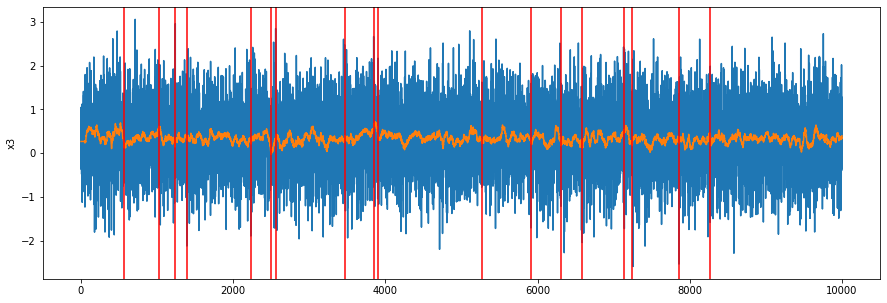

In [16]:
data_source_path = 'dane/series3.csv'
threshold = 0.6
window_size = 100
data_size = 50
change_detected_window = 50

change_points, means = method3(data_source_path, threshold, window_size, data_size, change_detected_window)
draw_change_points(data_source_path, change_points, means)

## Method 4 - based on z-score

We calculate z-score and if it exceeds given thresholds, we assume there is a concept drift.

In [17]:
def method4(data_source_path, threshold, window_size, data_size, change_detected_window):
    print(f'BEGIN: {data_source_path}')
    new_data = data_generator(data_source_path)

    data_set = collections.deque(data_size*[None], data_size)
    while data_set[0] is None:
        data_set.append(next(new_data))

    means = []
    stds = []
    i = data_size
    n = i

    change_ids = []
    change_detected = []
    
    population_mean = None
    population_var = None

    while data_set is not None:
        current_mean = mean(data_set)
        current_std = stdev(data_set)
        latest_observation = data_set[-1]
        
        if population_mean is None:
            population_mean = current_mean
            population_var = variance(data_set)
        else:
            old_mean = population_mean
            population_mean = old_mean + (latest_observation - old_mean)/n
            population_var += (latest_observation - old_mean)*(latest_observation - population_mean)
            n += 1
        
        population_std = sqrt(population_var/(n-2))

        SE = population_std / np.sqrt(data_size)
        z_score = np.absolute(current_mean - population_mean)/SE

        if z_score > threshold:
#             print(current_mean, popultion_mean, z_score, f'i = {i}')

            if not any(x in range(i-change_detected_window, i) for x in change_ids):
#                 print(current_z_score, z_score, current_threshold, f'i = {i}')
                change_ids.append(i)
    #             print(f'CHANGE DETECTED, z_score={z_score}, i = {i}')
                population_mean = current_mean
                population_var = 0
                n = data_size

        means.append(current_mean)
        stds.append(current_std)

        data = next(new_data)
        if data is not None:
            data_set.append(data)
        else:
            data_set = None
        i += 1

    print(f'END: {data_source_path}')
    return change_ids, means

BEGIN: dane/series1.csv
END: dane/series1.csv


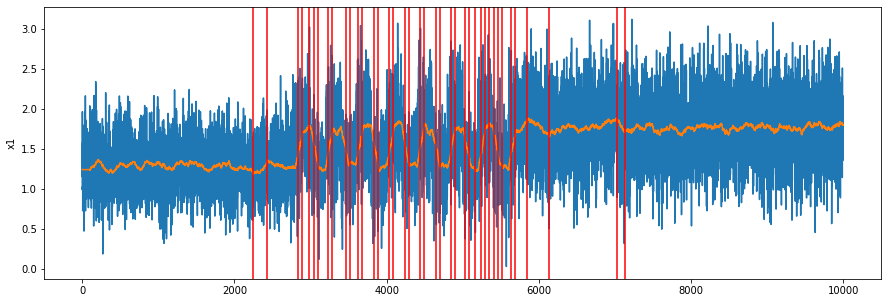

In [18]:
data_source_path = 'dane/series1.csv'
threshold = 3.0
window_size = 500
data_size = 100
change_detected_window = 50

change_points, means = method4(data_source_path, threshold, window_size, data_size, change_detected_window)
draw_change_points(data_source_path, change_points, means)

BEGIN: dane/series2.csv
END: dane/series2.csv


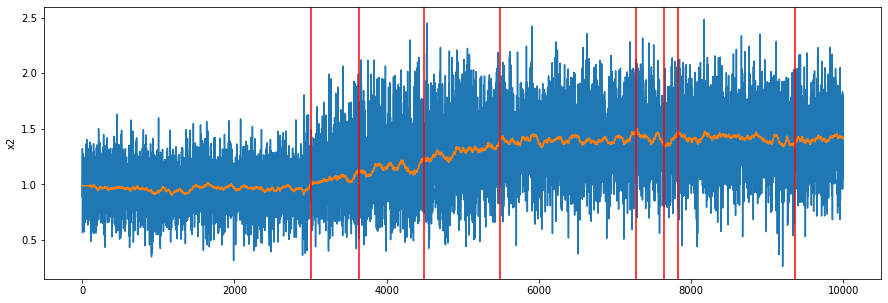

In [19]:
data_source_path = 'dane/series2.csv'
threshold = 3
window_size = 500
data_size = 100
change_detected_window = 50

change_points, means = method4(data_source_path, threshold, window_size, data_size, change_detected_window)
draw_change_points(data_source_path, change_points, means)

BEGIN: dane/series3.csv
END: dane/series3.csv


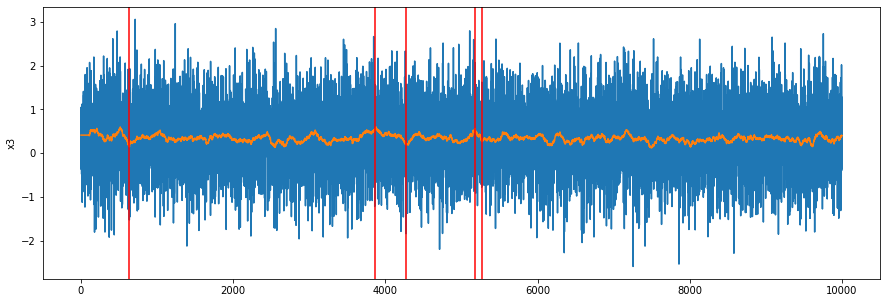

In [20]:
data_source_path = 'dane/series3.csv'
threshold = 3
window_size = 500
data_size = 100
change_detected_window = 50

change_points, means = method4(data_source_path, threshold, window_size, data_size, change_detected_window)
draw_change_points(data_source_path, change_points, means)

# Wnioski

- wykrywanie concept driftu nie jest łatwym zadaniem
- nie ma jednej uniwersalnej dobrej metody na wykrywanie concept driftu
- podejście z liczeniem zmian średniej działa dość dobrze (metoda 1)
- w ostatnim zbiorze większość metod jest dość wrażliwa na szum i oznacza go jako concept drift